In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
from torch.utils.data import DataLoader, Dataset


class CustomScaler:
    def __init__(self):
        self.u_min = float('inf')
        self.u_max = float('-inf')
    
    def partial_fit(self, batch):
        batch_min = np.min(batch)
        batch_max = np.max(batch)
        self.u_min = min(self.u_min, batch_min)
        self.u_max = max(self.u_max, batch_max)
    
    def fit(self, data_loader):
        for i, batch in enumerate(data_loader):
            self.partial_fit(batch.numpy())
            if i % 10 == 0:  # Print every 10 batches
                print(f"Batch {i}, Current min: {self.u_min:.6f}, Current max: {self.u_max:.6f}")
    
    def transform(self, u):
        u_scaled = (2 * u - (self.u_max + self.u_min)) / (self.u_max - self.u_min)
        return np.clip(u_scaled, -1, 1)
    
    def untransform(self, u_scaled):
        return 0.5 * (u_scaled * (self.u_max - self.u_min) + (self.u_max + self.u_min))

class GANDataset(Dataset):
    def __init__(self, folder_path, prefix):
        self.folder_path = folder_path
        self.prefix = prefix
        self.num_timesteps = 5000  # 0 to 4999

    def __len__(self):
        return self.num_timesteps

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, f'{self.prefix}_sample_{idx}.npy')
        data = np.load(file_path)
        return torch.from_numpy(data[0]).float()  # u = [0], v = [1] , w = [2]                       <--

def create_dataloader(dataset, batch_size=32):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

def save_scaler(scaler, path):
    with open(path, 'wb') as f:
        pickle.dump(scaler, f)

def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def fit_scaler(gen_folder_path, disc_folder_path, scaler_path, batch_size = 5000):                     # <--
    print(f"Fitting scaler with batch size: {batch_size}")
    scaler = CustomScaler()

    # Create DataLoaders
    gen_dataset = GANDataset(gen_folder_path, 'g')
    disc_dataset = GANDataset(disc_folder_path, 'd')

    gen_loader = create_dataloader(gen_dataset, batch_size)
    disc_loader = create_dataloader(disc_dataset, batch_size)

    # Fit the single scaler on both datasets
    print("Fitting scaler on generator data...")
    scaler.fit(gen_loader)
    print("Fitting scaler on discriminator data...")
    scaler.fit(disc_loader)

    # Save the scaler
    save_scaler(scaler, scaler_path)
    print(f"Scaler saved to {scaler_path}")
    
    return scaler

def extract_time_step(filename):
    """ 
    Extract the numeric part from the filename 'uvw_X.npy'
    """
    base = os.path.basename(filename)
    number_part = base.split('_')[1].split('.')[0] 
    return int(number_part)

# testing function (nine-grid sub-domain)

def block_picking_nine(path_1,path_2,path_3):
    """
    九宫格方法 (nine_grid method)
    """
    t_1 = np.load(path_1)
    t_2 = np.load(path_2)
    grid_3 = np.load(path_3)

    # width, height = grid_3.shape
    # min = 64 
    # max_x = width - 128
    # max_y = height - 128
    # x = np.random.randint(min, max_x + 1)
    # y = np.random.randint(min, max_y + 1)

    x = 64
    y = 64

    matrix_list = []
    true_matrix_list = []
    h_block = grid_3[y:y+64, x:x+64]
    for i, grid_1 in enumerate(t_1[:3], start=1):
        grid_2 = t_2[i-1]
        # Ensuring positive slices
        block_1_1 = grid_1[y-64:y, x-64:x]
        block_1_2 = grid_1[y-64:y, x:x+64]
        block_1_3 = grid_1[y-64:y, x+64:x+128]  
 
        block_2_1 = grid_1[y:y+64, x-64:x]
        block_2_2 = grid_1[y:y+64, x:x+64]
        block_2_3 = grid_1[y:y+64, x+64:x+128]
        
        block_3_1 = grid_1[y+64:y+128, x-64:x]
        block_3_2 = grid_1[y+64:y+128, x:x+64]
        block_3_3 = grid_1[y+64:y+128, x+64:x+128]

        block_t_n_plus = grid_2[y:y+64, x:x+64]

        stack_matrix = np.vstack([block_1_1, block_1_2, block_1_3, block_2_1, block_2_2, block_2_3, block_3_1, block_3_2, block_3_3])
        true_matrix_list.append(block_t_n_plus)
        matrix_list.append(stack_matrix)

    print(x,y)

    return matrix_list, true_matrix_list, h_block


path_1 = r"H:\DDGAN\nine_grid_testing\uvw_1_new.npy"
path_2 = r"H:\DDGAN\dataset\uvw_2.npy"
path_3 = r'H:\DDGAN\building_location.npy'
print(f"Processing pair: {path_1} and {path_2}")
stacked_matrix_list, center_matrix_list, h_block= block_picking_nine(path_1, path_2, path_3)

u_matrix_input = stacked_matrix_list[0]
v_matrix_input = stacked_matrix_list[1]
w_matrix_input = stacked_matrix_list[2]

u_c_matrix = center_matrix_list[0]
v_c_matrix = center_matrix_list[1]
w_c_matrix = center_matrix_list[2]

print(f"u_matrix size",{u_matrix_input.shape})
print(f"u_c_matrix size",{u_c_matrix.shape})

# np.save(os.path.join(output_directory_1, f"g_sample_1_1.npy"), [u_matrix_input, v_matrix_input, w_matrix_input])
# np.save(os.path.join(output_directory_2, f"d_sample_1_1.npy"), [u_c_matrix, v_c_matrix, w_c_matrix])

input_data = [u_matrix_input, v_matrix_input, w_matrix_input]
target_data = [u_c_matrix, v_c_matrix, w_c_matrix]

def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Paths
scalers_path = r'H:\DDGAN\plus_mask'                                                                       # <--                                            # <--
output_folder = r'H:\DDGAN\nine_grid_testing'                                           # <--
os.makedirs(output_folder, exist_ok=True)

# Load scalers
u_scaler = load_scaler(os.path.join(scalers_path, 'scaler_u.pkl'))
v_scaler = load_scaler(os.path.join(scalers_path, 'scaler_v.pkl'))
w_scaler = load_scaler(os.path.join(scalers_path, 'scaler_w.pkl'))

# Transform each matrix
transformed_input_data = np.array([
    u_scaler.transform(input_data[0]),
    v_scaler.transform(input_data[1]),
    w_scaler.transform(input_data[2])
    ])

transformed_output_data = np.array([
    u_scaler.transform(target_data[0]),
    v_scaler.transform(target_data[1]),
    w_scaler.transform(target_data[2])
    ])

building_file = os.path.join(output_folder, f'h_1_1')
np.save(building_file, h_block)
input_file = os.path.join(output_folder, f'g_1_1')
np.save(input_file, transformed_input_data)
# np.save(input_file, input_data)
output_file = os.path.join(output_folder, f'd_1_1')
np.save(output_file, transformed_output_data)
# np.save(output_file, target_data)
print(f"Processed and saved: {output_file}")

Processing pair: H:\DDGAN\nine_grid_testing\uvw_1_new.npy and H:\DDGAN\dataset\uvw_2.npy
64 64
u_matrix size {(576, 64)}
u_c_matrix size {(64, 64)}
Processed and saved: H:\DDGAN\nine_grid_testing\d_1_1


In [61]:
loaded_data = np.load(r'H:\DDGAN\nine_grid_testing\d_1_1.npy')
print(f"Output file shape: {loaded_data.shape}")
print(f"Minimum value: {np.min(loaded_data)}")
print(f"Maximum value: {np.max(loaded_data)}")

Output file shape: (3, 64, 64)
Minimum value: -0.5189210176467896
Maximum value: 0.4305436313152313



Accessing stored input velocity matrices:
Matrix 1 size: (576, 64)
Matrix 2 size: (576, 64)
Matrix 3 size: (576, 64)


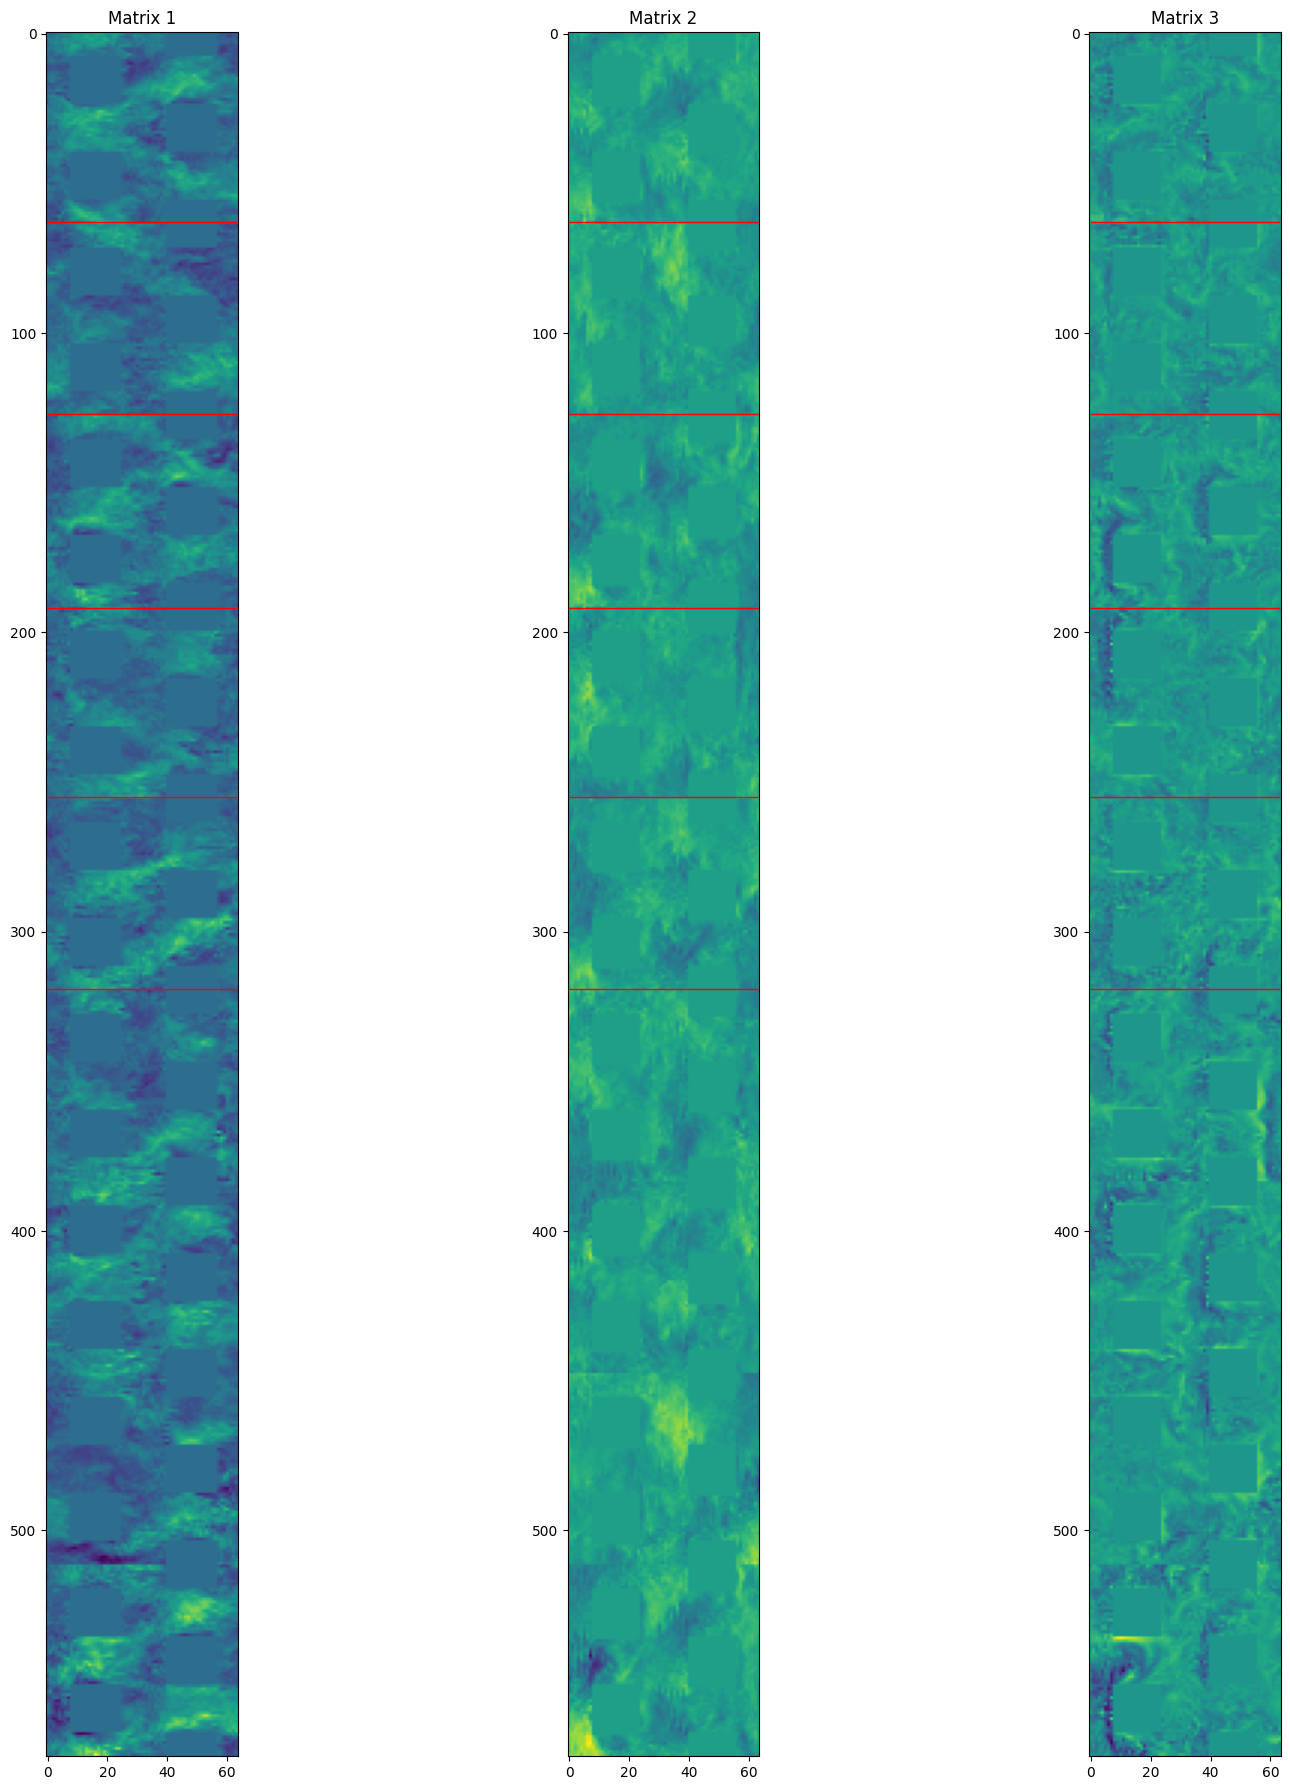

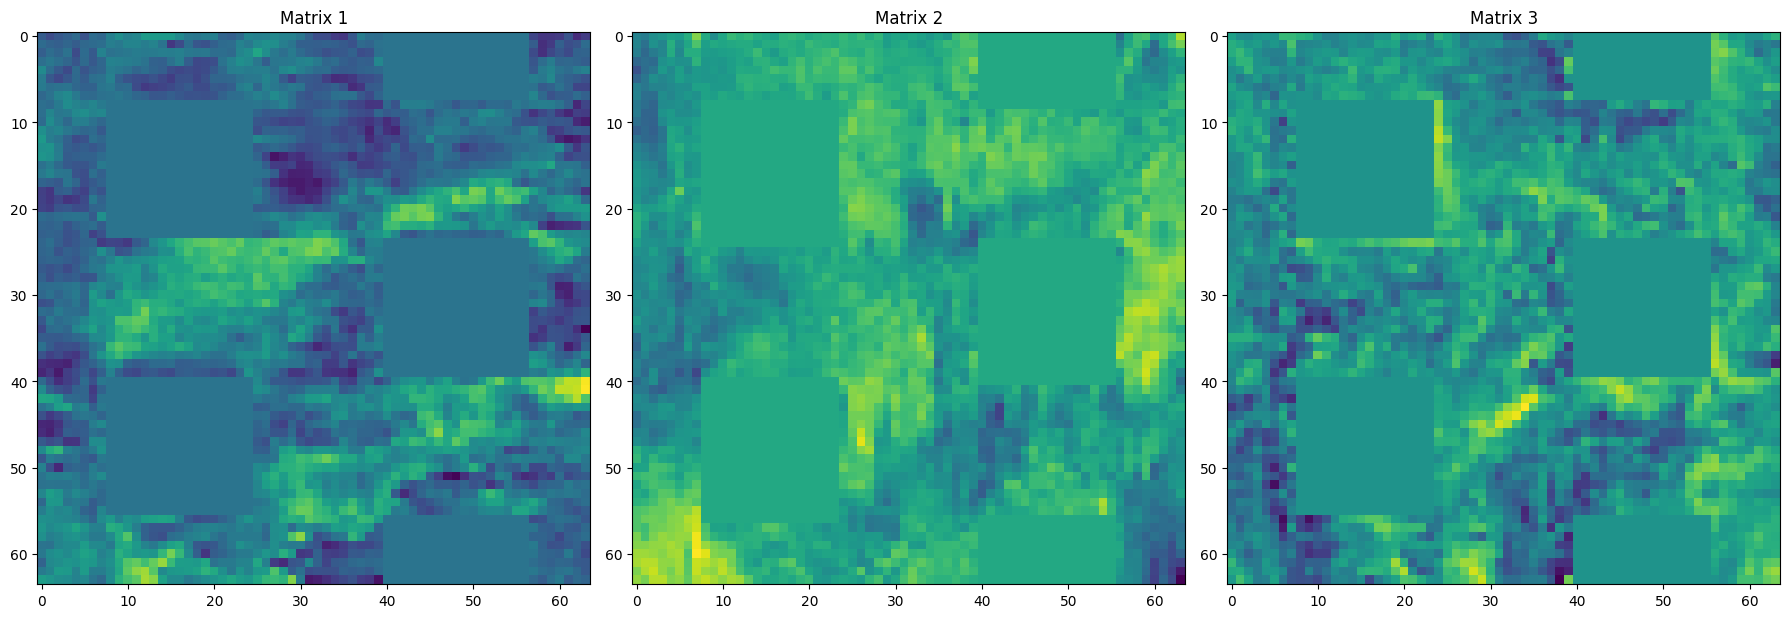

In [13]:
path_1 = r'H:\DDGAN\nine_grid_testing\g_1_1.npy'
path_2 = r'H:\DDGAN\nine_grid_testing\d_1_1.npy'
matrix = np.load(path_1)
matrix2 = np.load(path_2)

u = matrix[0]
v = matrix[1]
w = matrix[2]

u1 = matrix2[0]
v1 = matrix2[1]
w1 = matrix2[2]

matrix_list = [u,v,w]
matrix_list_2 = [u1,v1,w1]


print("\nAccessing stored input velocity matrices:")
for idx, mat in enumerate(matrix_list):
    print(f"Matrix {idx + 1} size: {mat.shape}")

lines = {
    'horizontal_1': ([63, 63], [0, 63]),
    'horizontal_2': ([127, 127], [0, 63]),
    'horizontal_3': ([192, 192], [0, 63]),
    'horizontal_4': ([255, 255], [0, 63]),
    'horizontal_5': ([319, 319], [0, 63])
}

num_matrices = len(matrix_list)
fig, axes = plt.subplots(1, num_matrices, figsize=(18, 18))
for i, matrix in enumerate(matrix_list):
        if num_matrices == 1:
            ax = axes
        else:
            ax = axes[i]
        cax = ax.imshow(matrix, cmap='viridis', aspect='equal')
        ax.set_title(f'Matrix {i + 1}')
        ax.xaxis.set_ticks_position('bottom')
        for line in lines.values():
            ax.plot(line[1], line[0], color='red', linewidth=1)
plt.tight_layout()
plt.show()

num_matrices = len(matrix_list_2)
fig, axes = plt.subplots(1, num_matrices, figsize=(18, 18))
for i, matrix in enumerate(matrix_list_2):
        if num_matrices == 1:
            ax = axes
        else:
            ax = axes[i]
        cax = ax.imshow(matrix, cmap='viridis', aspect='equal')
        ax.set_title(f'Matrix {i + 1}')
        ax.xaxis.set_ticks_position('bottom')
plt.tight_layout()
plt.show()

MSE: 0.0113
PSNR: 67.6025
SSIM: 0.1902
Shape of output_untransformed: (64, 64, 3)
Data saved to evaluation_results.mat


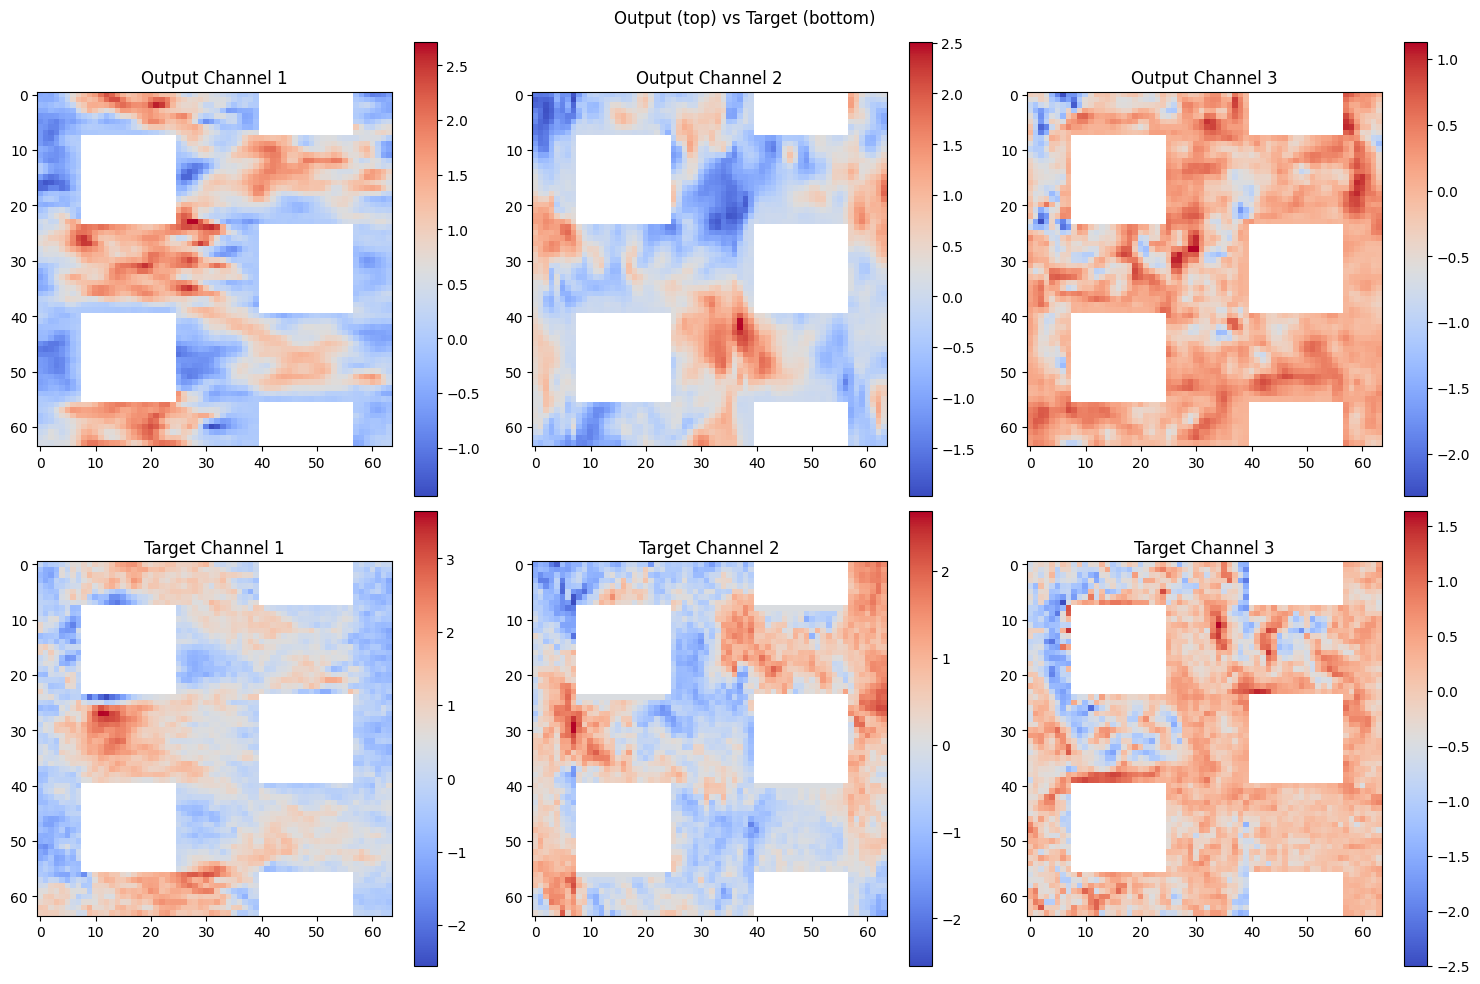

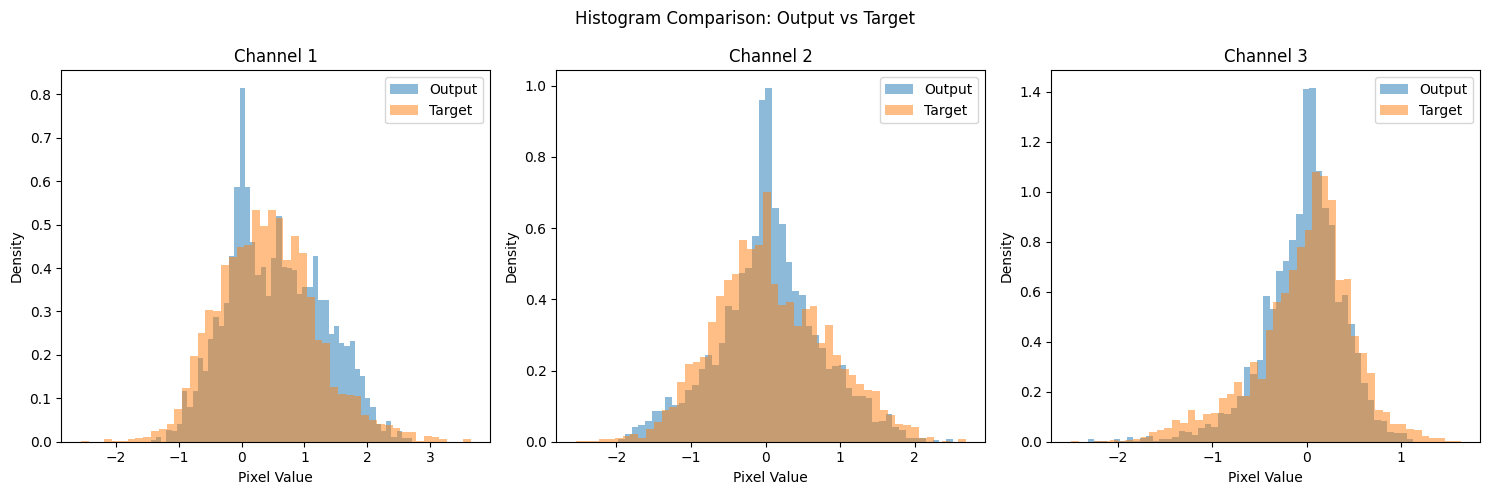

In [62]:
import torch
import pickle
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from nine_1 import FullModel  # Import your model architecture
from scipy import io as sio
import os
import glob
from torch.utils.data import DataLoader, Dataset
import re

# Load the model
model = FullModel()
# model.load_state_dict(torch.load(r'H:\DDGAN\nine_gird_model\model_final.pth'))
# model.load_state_dict(torch.load(r'H:\DDGAN\plus_mask_model\model_epoch_3900.pth'))
# model.eval()
class CustomScaler:
    def __init__(self):
        self.u_min = float('inf')
        self.u_max = float('-inf')
    
    def partial_fit(self, batch):
        batch_min = np.min(batch)
        batch_max = np.max(batch)
        self.u_min = min(self.u_min, batch_min)
        self.u_max = max(self.u_max, batch_max)
    
    def fit(self, data_loader):
        for i, batch in enumerate(data_loader):
            self.partial_fit(batch.numpy())
            if i % 10 == 0:  # Print every 10 batches
                print(f"Batch {i}, Current min: {self.u_min:.6f}, Current max: {self.u_max:.6f}")
    
    def transform(self, u):
        u_scaled = (2 * u - (self.u_max + self.u_min)) / (self.u_max - self.u_min)
        return np.clip(u_scaled, -1, 1)
    
    def untransform(self, u_scaled):
        return 0.5 * (u_scaled * (self.u_max - self.u_min) + (self.u_max + self.u_min))

class GANDataset(Dataset):
    def __init__(self, folder_path, prefix):
        self.folder_path = folder_path
        self.prefix = prefix
        self.num_timesteps = 5000  # 0 to 4999

    def __len__(self):
        return self.num_timesteps

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, f'{self.prefix}_sample_{idx}.npy')
        data = np.load(file_path)
        return torch.from_numpy(data[0]).float()  # u = [0], v = [1] , w = [2]                       <--

def create_dataloader(dataset, batch_size=32):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

def save_scaler(scaler, path):
    with open(path, 'wb') as f:
        pickle.dump(scaler, f)

def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def fit_scaler(gen_folder_path, disc_folder_path, scaler_path, batch_size = 5000):                     # <--
    print(f"Fitting scaler with batch size: {batch_size}")
    scaler = CustomScaler()

    # Create DataLoaders
    gen_dataset = GANDataset(gen_folder_path, 'g')
    disc_dataset = GANDataset(disc_folder_path, 'd')

    gen_loader = create_dataloader(gen_dataset, batch_size)
    disc_loader = create_dataloader(disc_dataset, batch_size)

    # Fit the single scaler on both datasets
    print("Fitting scaler on generator data...")
    scaler.fit(gen_loader)
    print("Fitting scaler on discriminator data...")
    scaler.fit(disc_loader)

    # Save the scaler
    save_scaler(scaler, scaler_path)
    print(f"Scaler saved to {scaler_path}")
    
    return scaler
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define evaluation metrics
mse_loss = nn.MSELoss()

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    min_dim = min(img1.shape[0], img1.shape[1])
    win_size = min(7, min_dim - (min_dim % 2) + 1)
    return ssim(img1, img2, win_size=win_size, data_range=img1.max() - img1.min(), channel_axis=2)

def evaluate_single_file(model, input_file, target_file, device):
    model.eval()
    
    # Load input and target data
    input_data = np.load(input_file)
    target_data = np.load(target_file)
    
    # Ensure correct shape and convert to tensor
    if input_data.shape != (64, 3, 576):
        input_data = input_data.transpose(2, 1, 0)
    input_tensor = torch.from_numpy(input_data).float().unsqueeze(0).to(device)
    
    if target_data.shape != (3, 64, 64):
        target_data = target_data.transpose(2, 0, 1)
    target_tensor = torch.from_numpy(target_data).float().unsqueeze(0).to(device)

    with torch.no_grad():
        # Forward pass
        output, _, _, _ = model(input_tensor)

        # Calculate MSE
        mse = mse_loss(output, target_tensor).item()

        # Calculate PSNR and SSIM
        output_np = output.cpu().numpy().squeeze().transpose(1, 2, 0)
        target_np = target_tensor.cpu().numpy().squeeze().transpose(1, 2, 0)
        
        psnr = calculate_psnr(output_np, target_np)
        ssim_value = calculate_ssim(output_np, target_np)

    return mse, psnr, ssim_value, output_np, target_np

def visualize_results_3channels(output, target):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Output (top) vs Target (bottom)')
    
    channel_names = ['Channel 1', 'Channel 2', 'Channel 3']
    
    for i in range(3):
        # Output image
        im = axs[0, i].imshow(output[:,:,i], cmap='coolwarm')
        axs[0, i].set_title(f'Output {channel_names[i]}')
        fig.colorbar(im, ax=axs[0, i])
        
        # Target image
        im = axs[1, i].imshow(target[:,:,i], cmap='coolwarm')
        axs[1, i].set_title(f'Target {channel_names[i]}')
        fig.colorbar(im, ax=axs[1, i])
    
    plt.tight_layout()
    plt.show()

def plot_histograms(output, target):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Histogram Comparison: Output vs Target')
    
    channel_names = ['Channel 1', 'Channel 2', 'Channel 3']
    
    for i in range(3):
        axs[i].hist(output[:,:,i].flatten(), bins=50, alpha=0.5, label='Output', density=True)
        axs[i].hist(target[:,:,i].flatten(), bins=50, alpha=0.5, label='Target', density=True)
        axs[i].set_title(f'{channel_names[i]}')
        axs[i].set_xlabel('Pixel Value')
        axs[i].set_ylabel('Density')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

def compute_histograms(image):
    histograms = [] 
    for i in range(3):
        hist, _ = np.histogram(image[:,:,i].flatten(), bins=50,range=(-6, 6), density=True)
        histograms.append(hist)
    return np.array(histograms)

def evaluate_single_file(model, input_file, target_file, device):
    model.eval()
    
    # Load input and target data
    input_data = np.load(input_file)
    target_data = np.load(target_file)
    
    # Ensure correct shape and convert to tensor
    if input_data.shape != (64, 3, 576):
        input_data = input_data.transpose(2, 1, 0)
    input_tensor = torch.from_numpy(input_data).float().unsqueeze(0).to(device)
    
    if target_data.shape != (3, 64, 64):
        target_data = target_data.transpose(2, 0, 1)
    target_tensor = torch.from_numpy(target_data).float().unsqueeze(0).to(device)

    # Now we can safely access input_tensor
    input_np = input_tensor.cpu().numpy().squeeze().transpose(1, 2, 0)

    with torch.no_grad():
        # Forward pass
        output, _, _, _ = model(input_tensor)

        # Calculate MSE
        mse = mse_loss(output, target_tensor).item()

        # Calculate PSNR and SSIM
        output_np = output.cpu().numpy().squeeze().transpose(1, 2, 0)
        target_np = target_tensor.cpu().numpy().squeeze().transpose(1, 2, 0)
        
        psnr = calculate_psnr(output_np, target_np)
        ssim_value = calculate_ssim(output_np, target_np)

    return mse, psnr, ssim_value, input_np, output_np, target_np

# Specify the input and target file paths
input_file = r"H:\DDGAN\nine_grid_testing\g_1_1.npy"  # Replace with your input file path
target_file = r"H:\DDGAN\nine_grid_testing\d_1_1.npy"  # Replace with your target file path
mask = np.load(r'H:\DDGAN\nine_grid_testing\h_1_1.npy')

model = FullModel()
model.load_state_dict(torch.load(r'H:\DDGAN\models\jz_hpc_5000_test_ng.pth'))
model.eval()

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Run evaluation
mse, psnr, ssim_value, input_data, output_data, target_data = evaluate_single_file(model, input_file, target_file, device)
print(f"MSE: {mse:.4f}")
print(f"PSNR: {psnr:.4f}")
print(f"SSIM: {ssim_value:.4f}")

# Visualize results with all 3 channels
# visualize_results_3channels(output, target)

scaler_u = load_scaler(r'H:\DDGAN\scaler_u.pkl')
scaler_v = load_scaler(r'H:\DDGAN\scaler_v.pkl')
scaler_w = load_scaler(r'H:\DDGAN\scaler_w.pkl')

if mask.shape[0] == 1:
    mask = np.squeeze(mask, axis=0)

def untransform(self, u_scaled):
    return 0.5 * (u_scaled * (self.u_max - self.u_min) + (self.u_max + self.u_min))

# Assuming scaler_u, scaler_v, scaler_w are instances of Scaler
# and output_data is your 3D array with shape (3, height, width)
output_u=output_data[:,:,0]
output_v=output_data[:,:,1]
output_w=output_data[:,:,2]
output_u = scaler_u.untransform(output_u)
output_v = scaler_v.untransform(output_v)
output_w = scaler_w.untransform(output_w)
output_u[mask] = np.nan
output_v[mask] = np.nan
output_w[mask] = np.nan
# Merge the untransformed data back into a 3D array
output_untransformed = np.stack((output_u, output_v, output_w), axis=0)
output_masked = output_untransformed.transpose(1,2,0)
print(f"Shape of output_untransformed: {output_masked.shape}")


target_data = np.load(target_file)
target_u = scaler_u.untransform(target_data[0])
target_v = scaler_v.untransform(target_data[1])
target_w = scaler_w.untransform(target_data[2])
target_u[mask] = np.nan
target_v[mask] = np.nan
target_w[mask] = np.nan
target_data = np.stack((target_u, target_v, target_w), axis=0)
target_data = target_data.transpose(1,2,0)
# Compute histograms
input_hist = compute_histograms(input_data)
output_hist = compute_histograms(output_data)
target_hist = compute_histograms(target_data)

# Plot histograms
# plot_histograms(output, target)

matlab_data = {
    'input_data': input_data,
    'output_data': output_data,
    'output_data_unnorm': output_masked,
    'target_data': target_data,
    'input_hist': input_hist,
    'output_hist': output_hist,
    'target_hist': target_hist,
    'mse': mse,
    'psnr': psnr,
    'ssim': ssim_value
}

# sio.savemat('evaluation_results_1_1.mat', matlab_data)
# np.save(r'H:\DDGAN\nine_grid_testing\2_2.npy', output_masked)
print("Data saved to evaluation_results.mat")

# Visualize results with all 3 channels
# visualize_results_3channels(output_data, target_data)
visualize_results_3channels(output_masked, target_data)

# Plot histograms
plot_histograms(output_masked, target_data)

In [52]:
data_1_1 = np.load(r'H:\DDGAN\nine_grid_testing\1_1.npy')
data_1_2 = np.load(r'H:\DDGAN\nine_grid_testing\1_2.npy')
data_2_1 = np.load(r'H:\DDGAN\nine_grid_testing\2_1.npy')
data_2_2 = np.load(r'H:\DDGAN\nine_grid_testing\2_2.npy')
mask = np.load(r'H:\DDGAN\building_location.npy')

output_u_1_1 = data_1_1[:,:,0]
output_v_1_1 = data_1_1[:,:,1]
output_w_1_1 = data_1_1[:,:,2]

output_u_1_2 = data_1_2[:,:,0]
output_v_1_2 = data_1_2[:,:,1]
output_w_1_2 = data_1_2[:,:,2]

output_u_2_1 = data_2_1[:,:,0]
output_v_2_1 = data_2_1[:,:,1]
output_w_2_1 = data_2_1[:,:,2]

output_u_2_2 = data_2_2[:,:,0]
output_v_2_2 = data_2_2[:,:,1]
output_w_2_2 = data_2_2[:,:,2]

u_merged_1 = np.hstack((output_u_1_1,output_u_1_2))
u_merged_2 = np.hstack((output_u_2_1,output_u_2_2))
u = np.vstack((u_merged_1,u_merged_2))

v_merged_1 = np.hstack((output_v_1_1,output_v_1_2))
v_merged_2 = np.hstack((output_v_2_1,output_v_2_2))
v = np.vstack((v_merged_1,v_merged_2))

w_merged_1 = np.hstack((output_w_1_1,output_w_1_2))
w_merged_2 = np.hstack((output_w_2_1,output_w_2_2))
w = np.vstack((w_merged_1,w_merged_2))

total_flow = np.stack((u, v, w), axis=0)

new_time = np.load(r'H:\DDGAN\nine_grid_testing\uvw_1_masked.npy')

target_fd = np.stack((new_time[0], new_time[1], new_time[2]), axis=2)

new_u = new_time[0]
new_v = new_time[1]
new_w = new_time[2]

start_row, start_col = 64, 64
area_height, area_width = 128, 128

target_u = new_u[start_row:start_row+area_height, start_col:start_col+area_width]
target_v = new_v[start_row:start_row+area_height, start_col:start_col+area_width]
target_w = new_w[start_row:start_row+area_height, start_col:start_col+area_width]


target_128 = np.stack((target_u, target_v, target_w), axis = 2)                         # 128*128*3 for data plottting

# Full domain with mask applied
 
new_u[start_row:start_row+area_height, start_col:start_col+area_width] = u
new_v[start_row:start_row+area_height, start_col:start_col+area_width] = v
new_w[start_row:start_row+area_height, start_col:start_col+area_width] = w

new_u[mask] = np.nan
new_v[mask] = np.nan
new_w[mask] = np.nan

u_masked = new_u[start_row:start_row+area_height, start_col:start_col+area_width]
v_masked = new_v[start_row:start_row+area_height, start_col:start_col+area_width]
w_masked = new_w[start_row:start_row+area_height, start_col:start_col+area_width]

output_128 = np.stack((u_masked, v_masked, w_masked), axis = 2)                                              # 128*128*3 for data plottting

output_fd = np.stack((new_u, new_v, new_w), axis=0)                                     # 256*256*3 for new iteration

(256, 256)


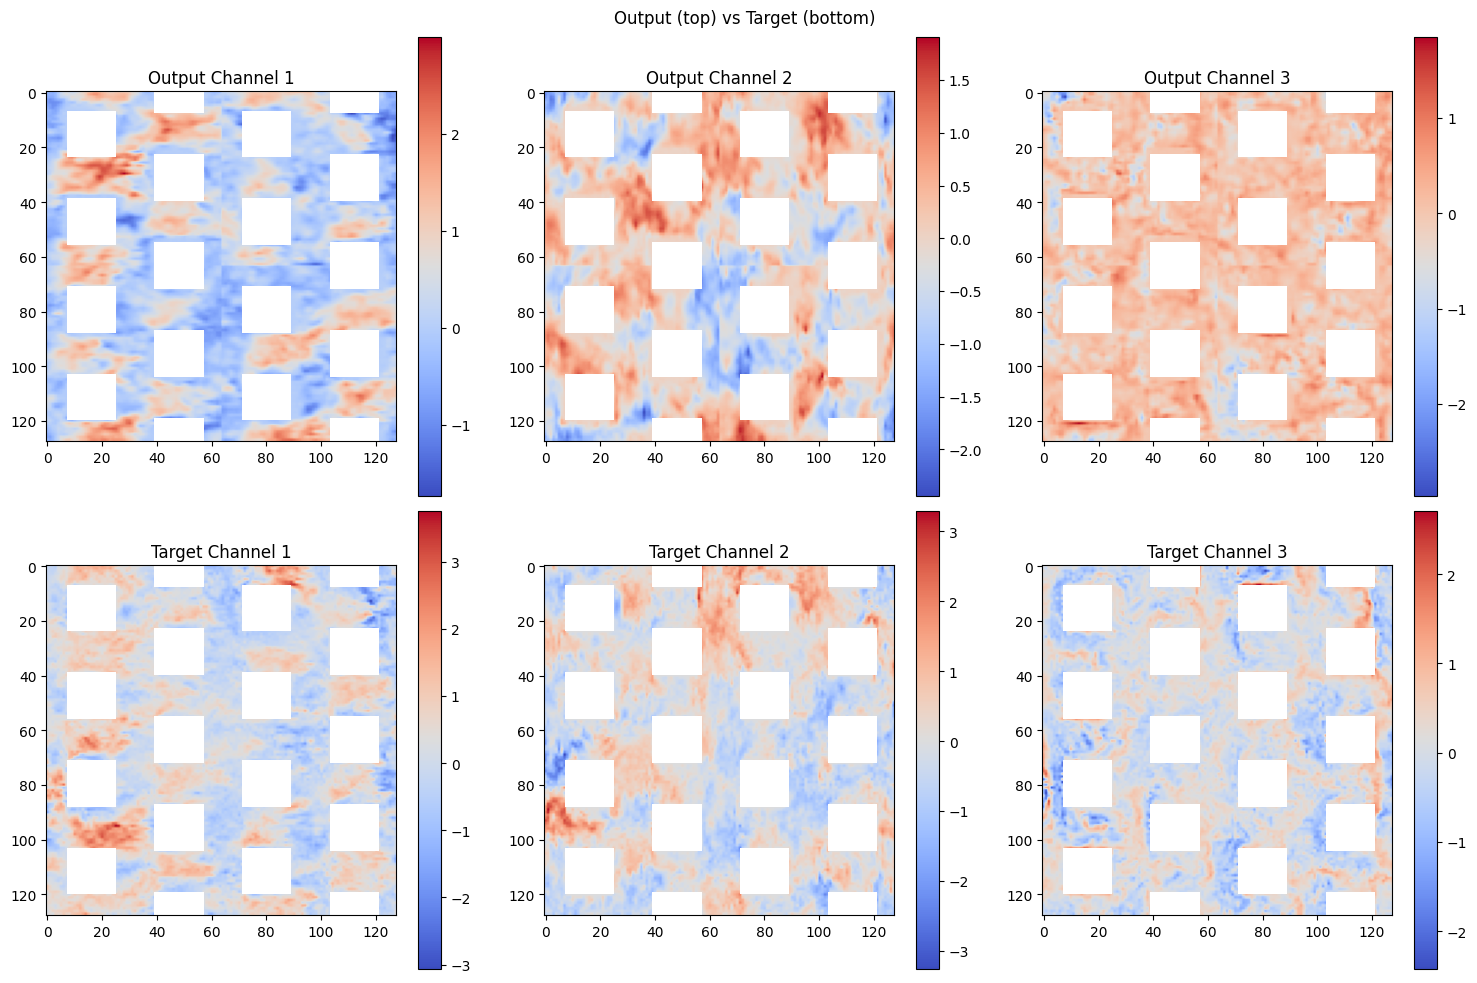

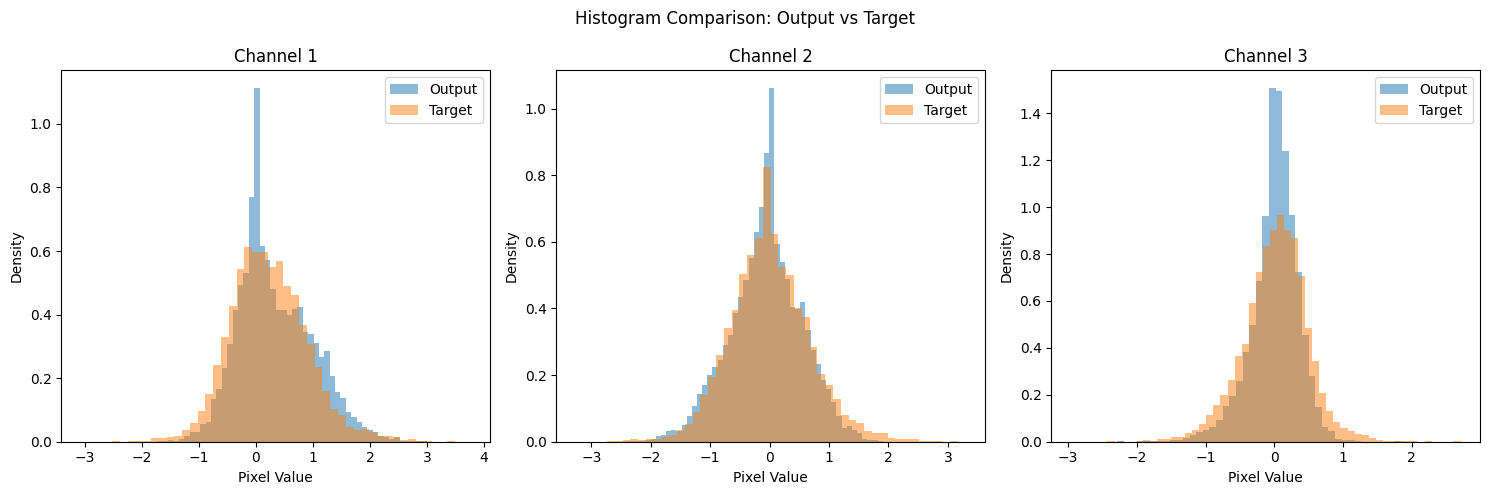

In [56]:
print(new_u.shape)
visualize_results_3channels(output_128, target_128)
plot_histograms(output_128, target_128)

output_hist = compute_histograms(output_128)
target_hist = compute_histograms(target_128)

matlab_data = {
    'output_data_unnorm': output_128,
    'target_data': target_128,
    'output_hist': output_hist,
    'target_hist': target_hist,
}

sio.savemat('evaluation_results_new_1.mat', matlab_data)